## Low-Tubal-Rank Autoregressive Tensor Completion Imputer (LATC-Tubal-imputer)

This notebook shows how to implement a LATC imputer on some real-world data sets (e.g., PeMS traffic speed data, Guangzhou traffic speed data). To overcome the problem of missing values within multivariate time series data, this method takes into account both low-rank structure and time series regression. For an in-depth discussion of LATC-imputer, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Author Name (2020). <b>Low-Rank Autorgressive Tensor Completion for Multivariate Time Series Forecasting</b>. arXiv.2006. <a href="xx" title="PDF"><b>[PDF]</b></a> 
</font>
</div>


In [1]:
import numpy as np
from numpy.linalg import inv as inv
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Define LATC-imputer kernel

We start by introducing some necessary functions that relies on `Numpy`.

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>ten2mat</code>:</b> <font color="black">Unfold tensor as matrix by specifying mode.</font></li>
<li><b><code>mat2ten</code>:</b> <font color="black">Fold matrix as tensor by specifying dimension (i.e, tensor size) and mode.</font></li>
<li><b><code>svt</code>:</b> <font color="black">Implement the process of Singular Value Thresholding (SVT).</font></li>
</ul>
</div>

In [2]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

In [3]:
def unitary_transform(tensor, Phi):
    return np.einsum('kt, ijk -> ijt', Phi, tensor)

def inv_unitary_transform(tensor, Phi):
    return np.einsum('kt, ijt -> ijk', Phi, tensor)

In [4]:
def tsvt(tensor, Phi, tau):
    dim = tensor.shape
    X = np.zeros(dim)
    tensor = unitary_transform(tensor, Phi)
    for t in range(dim[2]):
        u, s, v = np.linalg.svd(tensor[:, :, t], full_matrices = False)
        r = len(np.where(s > tau)[0])
        if r >= 1:
            s = s[: r]
            s[: r] = s[: r] - tau
            X[:, :, t] = u[:, : r] @ np.diag(s) @ v[: r, :]
    return inv_unitary_transform(X, Phi)

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>compute_mape</code>:</b> <font color="black">Compute the value of Mean Absolute Percentage Error (MAPE).</font></li>
<li><b><code>compute_rmse</code>:</b> <font color="black">Compute the value of Root Mean Square Error (RMSE).</font></li>
</ul>
</div>

> Note that $$\mathrm{MAPE}=\frac{1}{n} \sum_{i=1}^{n} \frac{\left|y_{i}-\hat{y}_{i}\right|}{y_{i}} \times 100, \quad\mathrm{RMSE}=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}},$$ where $n$ is the total number of estimated values, and $y_i$ and $\hat{y}_i$ are the actual value and its estimation, respectively.

In [5]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

The main idea behind LATC-imputer is to approximate partially observed data with both low-rank structure and time series dynamics. The following `imputer` kernel includes some necessary inputs:

<div class="alert alert-block alert-warning">
<ul>
<li><b><code>dense_tensor</code>:</b> <font color="black">This is an input which has the ground truth for validation. If this input is not available, you could use <code>dense_tensor = sparse_tensor.copy()</code> instead.</font></li>
<li><b><code>sparse_tensor</code>:</b> <font color="black">This is a partially observed tensor which has many missing entries.</font></li>
<li><b><code>time_lags</code>:</b> <font color="black">Time lags, e.g., <code>time_lags = np.array([1, 2, 3])</code>. </font></li>
<li><b><code>alpha</code>:</b> <font color="black">Weights for tensors' nuclear norm, e.g., <code>alpha = np.ones(3) / 3</code>. </font></li>
<li><b><code>rho</code>:</b> <font color="black">Learning rate for ADMM, e.g., <code>rho = 0.0005</code>. </font></li>
<li><b><code>lambda0</code>:</b> <font color="black">Weight for time series regressor, e.g., <code>lambda0 = 5 * rho</code>. If <code>lambda0 = 0</code>, then this imputer is actually a standard low-rank tensor completion (i.e., High-accuracy Low-Rank Tensor Completion, or HaLRTC).</font></li>
<li><b><code>epsilon</code>:</b> <font color="black">Stop criteria, e.g., <code>epsilon = 0.001</code>. </font></li>
<li><b><code>maxiter</code>:</b> <font color="black">Maximum iteration to stop algorithm, e.g., <code>maxiter = 50</code>. </font></li>
</ul>
</div>


In [6]:
def imputer(dense_tensor, sparse_tensor, time_lags, rho0, lambda0, epsilon, maxiter):
    """Low-Tubal-Rank Autoregressive Tensor Completion, LATC-Tubal-imputer."""
    dim = np.array(sparse_tensor.shape)
    dim_time = np.int(np.prod(dim) / dim[0])
    d = len(time_lags)
    max_lag = np.max(time_lags)
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    T = np.zeros(dim)                         # \boldsymbol{\mathcal{T}}
    Z = sparse_mat.copy()                     # \boldsymbol{Z}
    Z[pos_missing] = np.mean(sparse_mat[sparse_mat != 0])
    A = 0.001 * np.random.rand(dim[0], d)     # \boldsymbol{A}
    it = 0
    ind = np.zeros((d, dim_time - max_lag), dtype = np.int_)
    for i in range(d):
        ind[i, :] = np.arange(max_lag - time_lags[i], dim_time - time_lags[i])
    last_mat = sparse_mat.copy()
    snorm = np.linalg.norm(sparse_mat, 'fro')
    rho = rho0
    Phis = []
    temp1 = ten2mat(mat2ten(Z, dim, 0), 2)
    _, Phi = np.linalg.eig(temp1 @ temp1.T)
    Phis.append(Phi)
    del temp1
    if (dim_time > 5e3) and (dim_time <= 1e4):
        sample_rate = 0.2
    elif dim_time > 1e4:
        sample_rate = 0.1
    while True:
        rho = min(rho * 1.05, 1e5)
        X = tsvt(mat2ten(Z, dim, 0) - T / rho, Phi, 1 / rho)
        mat_hat = ten2mat(X, 0)
        mat0 = np.zeros((dim[0], dim_time - max_lag))
        temp2 = ten2mat(rho * X + T, 0)
        if lambda0 > 0:
            if dim_time <= 5e3:
                for m in range(dim[0]):
                    Qm = mat_hat[m, ind].T
                    A[m, :] = np.linalg.pinv(Qm) @ Z[m, max_lag :]
                    mat0[m, :] = Qm @ A[m, :]
            elif dim_time > 5e3:
                for m in range(dim[0]):
                    idx = np.arange(0, dim_time - max_lag)
                    np.random.shuffle(idx)
                    idx = idx[: int(sample_rate * (dim_time - max_lag))]
                    Qm = mat_hat[m, ind].T
                    A[m, :] = np.linalg.pinv(Qm[idx[:], :]) @ Z[m, max_lag:][idx[:]]
                    mat0[m, :] = Qm @ A[m, :]
            Z[pos_missing] = np.append((temp2[:, : max_lag] / rho), (temp2[:, max_lag :] + lambda0 * mat0) 
                                       / (rho + lambda0), axis = 1)[pos_missing]
        else:
            Z[pos_missing] = temp2[pos_missing] / rho
        T = T + rho * (X - mat2ten(Z, dim, 0))
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 10 == 0:
            temp1 = ten2mat(mat2ten(Z, dim, 0) - T / rho, 2)
            _, Phi = np.linalg.eig(temp1 @ temp1.T)
            Phis.append(Phi)
            del temp1
        if it % 50 == 0:
            print('Iter: {}'.format(it))
            print('Tolerance: {:.6}'.format(tol))
            var = dense_tensor[pos_test]
            var_hat = X[pos_test]
            print('MAPE: {:.6}'.format(compute_mape(var, var_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(var, var_hat)))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break

    print('Total iteration: {}'.format(it))
    print('Tolerance: {:.6}'.format(tol))
    var = dense_tensor[pos_test]
    var_hat = X[pos_test]
    print('Imputation MAPE: {:.6}'.format(compute_mape(var, var_hat)))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(var, var_hat)))
    print()
    
    return X, Phis

If you want to set parameters reasonably, please use this cross validation on your data set.

### California data - 4W

We generate **random missing (RM)** values on California traffic speed data set.

In [7]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_tensor = mat2ten(data.values, np.array([data.values.shape[0], 288, 4 * 7]), 0)
random_tensor = np.random.rand(data.values.shape[0], 288, 4 * 7)

missing_rate = 0.7

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)
del data, random_tensor, binary_tensor

In [8]:
time_lags = np.array([1, 2, 3, 4, 5, 6, 286, 287, 288, 289, 290, 291])
rho = 1e-4
lambda0 = 5 * rho
epsilon = 1e-3
maxiter = 100
tensor_hat, Phi = imputer(dense_tensor, sparse_tensor, time_lags, rho, lambda0, epsilon, maxiter)

Iter: 50
Tolerance: 0.00195328
MAPE: 0.0240088
RMSE: 2.2224

Total iteration: 69
Tolerance: 0.000937816
Imputation MAPE: 0.0239806
Imputation RMSE: 2.22587



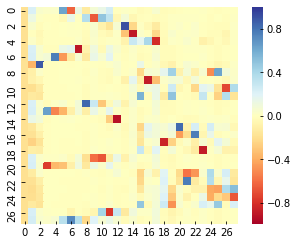

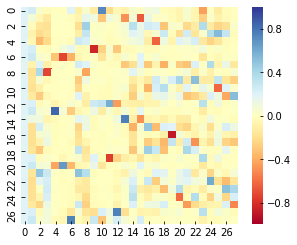

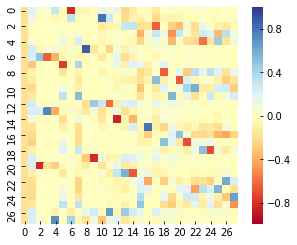

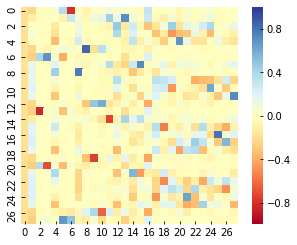

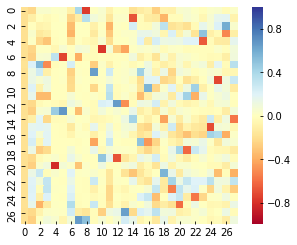

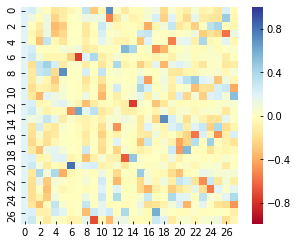

In [63]:
plt.style.use('bmh')
for i in range(6):
    fig = plt.figure(figsize = (5, 4))
    ax = sns.heatmap(Phi[i],vmax = 1, vmin = -1, square = True, cmap = 'RdYlBu')
    plt.show()
    fig.savefig("../images/unitary_matrix_{}0.pdf".format(i))

In [65]:
dense_mat = ten2mat(dense_tensor, 0)
sparse_mat = ten2mat(sparse_tensor, 0)
mat_hat = ten2mat(tensor_hat, 0)
del dense_tensor, sparse_tensor, tensor_hat

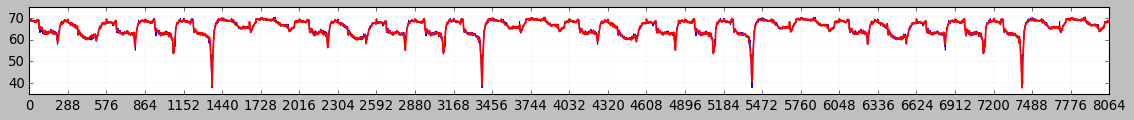

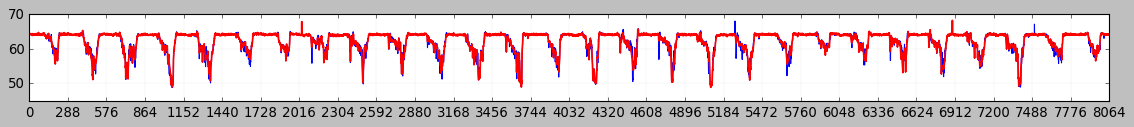

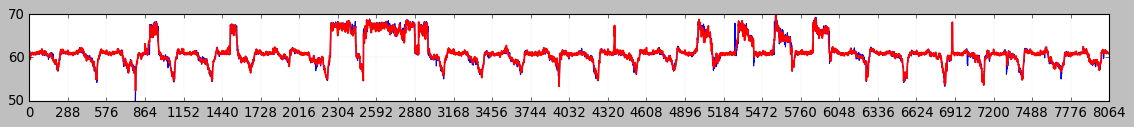

In [151]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

t = 28 * 288
axis_font = {'fontname':'Arial'}
plt.style.use('classic')
for i in [0, 9, 19]:
    fig = plt.figure(figsize=(15, 1.5))
    ax = fig.add_axes([0.05, 0.20, 0.90, 0.72])
    vec = sparse_mat[i, : t]
    pos = np.where(vec > 0)
    plt.plot(dense_mat[i, : t], color = 'b', linewidth = 1)
    plt.plot(mat_hat[i, : t], color = 'r', linewidth = 1.5)
    plt.xticks(np.arange(0, 288 * 28 + 1, 288))
    plt.yticks(np.arange(0, 80 + 1, 10))
    ax.set_xlim([0, t])
    if i == 0:
        ax.set_ylim([35, 75])
    elif i == 9:
        ax.set_ylim([45, 70])
    elif i == 19:
        ax.set_ylim([50, 70])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.5)
    plt.show()
    fig.savefig("../images/4w_time_series_{}.pdf".format(i + 1))